### Загрузка датасета COCO и кода COCO API

In [10]:
# Google-диск, пути для сохранения архива и обученной модели
from google.colab import drive
from pathlib import Path
drive.mount('/content/drive')
path = Path('/content/drive/My Drive/Skillbox/model_COCO')
path.mkdir(exist_ok=True, parents=True)
assert path.exists()
cpt_filename = 'checkpoint_best.h5'
cpt_path = str(path / cpt_filename)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
#!mkdir -p path

!cd /content/drive/MyDrive/Skillbox/model_COCO && wget http://images.cocodataset.org/zips/train2017.zip 
!cd /content/drive/MyDrive/Skillbox/model_COCO && wget http://images.cocodataset.org/zips/val2017.zip 
!cd /content/drive/MyDrive/Skillbox/model_COCO && wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip 
  
!cd /content/drive/MyDrive/Skillbox/model_COCO && unzip -q train2017.zip
!cd /content/drive/MyDrive/Skillbox/model_COCO && unzip -q val2017.zip
!cd /content/drive/MyDrive/Skillbox/model_COCO && unzip -q annotations_trainval2017.zip

!cd /content/drive/MyDrive/Skillbox/model_COCO && git clone https://github.com/cocodataset/cocoapi
!cd /content/drive/MyDrive/Skillbox/model_COCO/cocoapi/PythonAPI && make

--2021-05-08 08:03:24--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.10.36
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.10.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  32.1MB/s    in 9m 54s  

2021-05-08 08:13:18 (31.1 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]

--2021-05-08 08:13:18--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.133.99
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.133.99|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  13.9MB/s    in 53s     

2021-05-08 08:14:12 (14.7 MB/s) - ‘val

### Импорт необходимых библиотек

In [16]:
import os
import skimage.io as io
import numpy as np
import tensorflow as tf
#tf.enable_eager_execution()
print('TensorFlow version:', tf.__version__)
from livelossplot.tf_keras import PlotLossesCallback
import matplotlib.pyplot as plt

TensorFlow version: 2.4.1


### Импорт библиотеки COCO API
Там содержатся различные функции для чтения и обработки датасета COCO

In [3]:
COCO_ROOT = '/content/drive/My Drive/Skillbox/model_COCO'
import sys
sys.path.insert(0, os.path.join(COCO_ROOT, 'cocoapi/PythonAPI'))
from pycocotools.coco import COCO

### Наш класс Dataset
Этот класс конструирует экземпляры `tf.data.Dataset` и является универсальным для сегментации (подходит для использования с различными датасетами)

Однако, это абстрактный класс, в котром не реализован метод чтения датасета с диска, так как этот метод может отличаться для разных датасетов

In [4]:
class Dataset():

    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)

        if random_crop:
#            img = tf.random_crop(img, (inp_size, inp_size, shape[2]))
            img = tf.image.random_crop(img, (inp_size, inp_size, shape[2]))
        else: # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :]

        return img

    def train_dataset(self, batch_size, epochs, inp_size):

        def item_to_images(item):
            random_crop = True
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        dataset = dataset.map(item_to_images)
        dataset = dataset.repeat(epochs)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

    def val_dataset(self, batch_size, inp_size):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

### Наш класс COCO_Dataset
Класс, наследованный от нашего класса `Dataset`, в котром реализован метод `read_images`, специфичный для датасета COCO

In [5]:
class COCO_Dataset(Dataset):

    def __init__(self, sublist):
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)

    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined

### Создание обучающего и валидационного датасета
Сначала создаются два экземпляра класса `COCO_Dataset`, в конструкторе которого указывается тип датасета (указание для COCO - откуда какие читать изображения)

Далее вызываются функции `train_dataset` и `val_dataset` которые создают экземпляры `tf.data.Dataset` (в первом и втором случае логика и пайплайн данных в этих датасетов отличаются)

In [6]:
COCO_dataset_train = COCO_Dataset('train')
COCO_dataset_val = COCO_Dataset('val')

loading annotations into memory...
Done (t=27.11s)
creating index...
index created!
loading annotations into memory...
Done (t=0.96s)
creating index...
index created!


------------ далее МОЙ код ----------

In [7]:
train_ds = COCO_dataset_train.train_dataset(batch_size=32, epochs=1, inp_size=256)
val_ds = COCO_dataset_val.val_dataset(batch_size=16, inp_size=256)

In [8]:
# Создаем модель для работы в Colab на базе стандартной U-Net. Уменьшаем количество нейронов,
# иначе Colab не потянет по ОЗУ

def build_model():
    x = tf.keras.layers.Input((256, 256, 3))
    
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    out1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out1)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out2)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out3 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out3)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out4 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out4)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out4, out], axis=3)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out3, out], axis=3)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out2, out], axis=3)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out1, out], axis=3)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(out)

    return tf.keras.Model(inputs=x, outputs=out)

model = build_model()

In [11]:
# define ModelCheckpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='accuracy', verbose=1, save_best_only=True, mode='max')

In [12]:
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

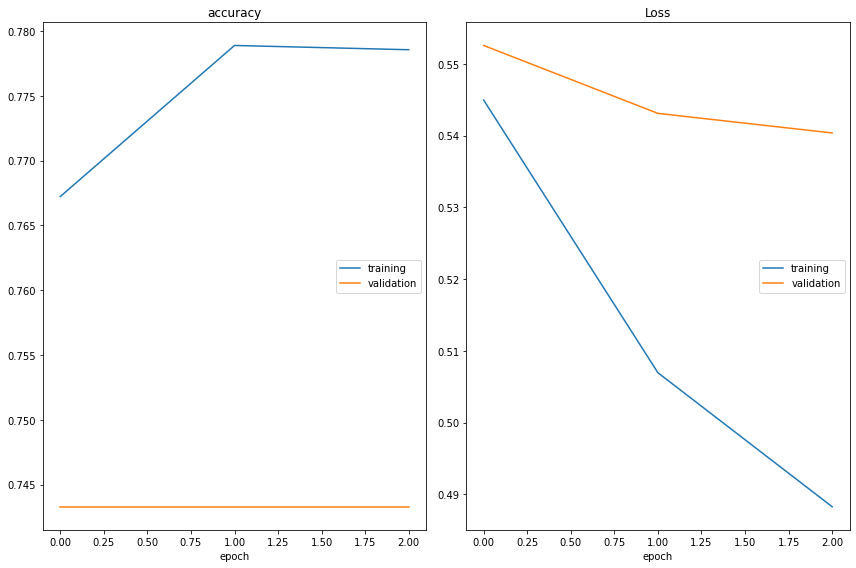

accuracy
	training         	 (min:    0.767, max:    0.779, cur:    0.779)
	validation       	 (min:    0.743, max:    0.743, cur:    0.743)
Loss
	training         	 (min:    0.488, max:    0.545, cur:    0.488)
	validation       	 (min:    0.540, max:    0.553, cur:    0.540)

Epoch 00003: accuracy did not improve from 0.77888


In [13]:
history = model.fit(train_ds,validation_data=val_ds, epochs=3, steps_per_epoch=32, callbacks=[PlotLossesCallback(), checkpoint])

In [59]:
# Запись событий в обратном вызове callbacks
history.history

{'accuracy': [0.7672207951545715, 0.7788811922073364, 0.7785519957542419],
 'loss': [0.5449450016021729, 0.5069524645805359, 0.4882766902446747],
 'val_accuracy': [0.7432888150215149, 0.7432888150215149, 0.7432888150215149],
 'val_loss': [0.5525552034378052, 0.5430909395217896, 0.5403631329536438]}

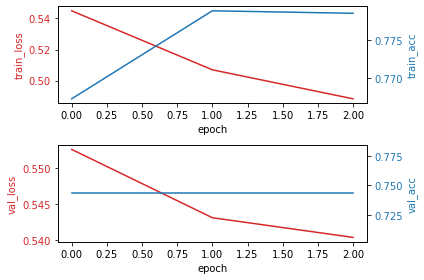

In [60]:
from tensorflow_history_plot import show_acc
show_acc.plot(history)

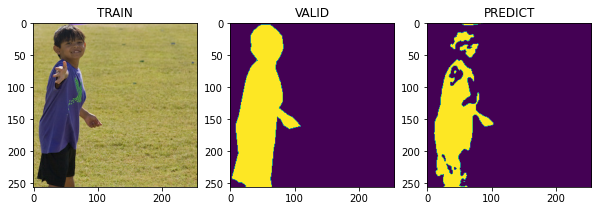

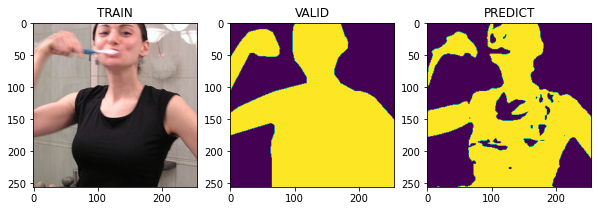

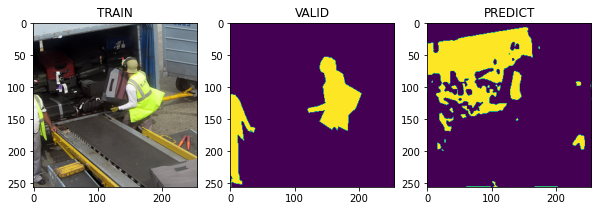

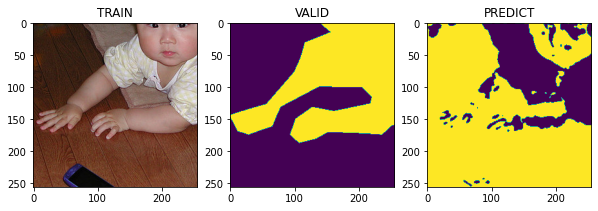

In [64]:
val_ds = val_ds.shuffle(20000)
for img in val_ds.take(4):
    plt.figure(figsize=(10,16))
    plt.subplot(131) # X_train
    plt.title('TRAIN')
    plt.imshow(img[0][0, :, :, :])
    plt.subplot(132)  # X_val
    plt.title('VALID')
    plt.imshow(img[1][0, :, :, 0])
    plt.subplot(133)  # X_pred
    plt.title('PREDICT')
    out = (model.predict(img[0]))[0,:,:,0] > .3
    plt.imshow(out)
    plt.show()